## Importing the libraries

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import os
import seaborn as sns

## Importing the dataset

In [94]:
def loadData(dataset): 
    """
    Loading the data using Pandas and os.path. This module implements some useful functions on pathnames
    allowing us to get access to the filesystem and download the data
    
    @Author : Hatim EL MALKI
    """
    missing_values=["?", "\t?"]
    csv_path = os.path.join(os.getcwd(), dataset) 
    return pd.read_csv(csv_path, na_values=missing_values)

## Data Preprocessing

In [95]:
def preprocessing(df):
    """
    Computing the average value on the features and use it to fill the missing values in our DataSet.
    Normalization of the DataSet by using Min-max scaling : 
        -> Values are shifted and rescaled so that they end up ranging from 0 to 1. 
        -> We do this by subtracting the min value and dividing by the max minus the min. 
        
    @Author : Hatim EL MALKI
    """
    cat_col = df.select_dtypes(include=['object']).columns # get categorical columns 
    num_col = [x for x in df.columns if x not in cat_col] # get the numerical columns 
    label_col = df.columns[-1] # get the labels column 

    # Min-Max Normalization of the DataSet
    for x in num_col:
        mean = df[x].mean() # average of x column 
        df[x]=df[x].fillna(mean) # replace the missing values by average  
        minimum = df[x].min() # get the minimum of x column 
        maximum = df[x].max() # get the maximum of x column 
        
        df[x]=(df[x]-minimum)/(maximum-minimum) # Apply the min-max normalization on x column 
        
    # Remove Blanks from the labels Column     
    for y in cat_col :
        df[y]=df[y].str.strip()
    
    # Encode Categorical Data
    le = LabelEncoder() 
    le.fit(df[label_col]) # fit the labelEncoder
    label = le.transform(df[label_col]) # Encode the labels column 
    df = df.drop([label_col], axis = 1) # Drop the categorical label column
    new_df = pd.get_dummies(df) # Convert categorical variable except the labels 
    new_df[label_col] = label # Add the encoded labels column 
    
    
    return new_df

## Data Visualization

In [112]:
def visualizeData(df):
    """
    Visualizing our DataSet by plotting a simple scatter of 2 different features one plotted along the x-axis 
    and the other plotted along the y-axis
    
    @Author : Hamid MASSAOUD
    """
    num_col = df.select_dtypes(include=['float64']).columns # get Numerical columns 
    if 'id' in num_col : 
        df = df.drop(['id'], axis='columns') 
    fig, axes = plt.subplots(nrows=int(len(num_col)/2), ncols=int(len(num_col)/2), figsize=(20,10))
    fig.tight_layout()

    plots = [(i, j) for i in range(len(num_col)) for j in range(len(num_col)) if i!=j]
    colors = ['g', 'y']
    labels = ['0', '1']

    for i, ax in enumerate(axes.flat):
        for j in range(2):
            x = df.columns[plots[i][0]]
            y = df.columns[plots[i][1]]
            ax.scatter(df[df[df.columns[-1]]==j][x], df[df[df.columns[-1]]==j][y], color=colors[j])
            ax.set(xlabel=x, ylabel=y)

    fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
    plt.show()

## Selecting features based on Correlation

In [97]:
def dataCorrelation(df):
    """
    Compare the correlation between features and remove one of two features 
    that have a correlation higher than 0.9
    
    @Author : Hamid MASSAOUD
    """
    corr_matrix = df.corr()
    plt.figure(figsize=(20,10))
    sns.heatmap(corr_matrix)
    plt.title('Correlation heatmap for the DataSet')
    plt.show()
    
    columns = np.full((corr_matrix.shape[0],), True, dtype=bool)
    for i in range(corr_matrix.shape[0]):
        for j in range(i+1, corr_matrix.shape[0]):
            if corr_matrix.iloc[i,j] >= 0.9:
                if columns[j]:
                    columns[j] = False
    selected_columns = df.columns[columns]
    df = df[selected_columns]
    return df

## Splitting the dataset into the Training set and Test set

In [98]:
def split(df):
    X = df.iloc[:, :-1].values # get the features 
    labels = df.iloc[:,-1].values # get the labels   
    
    # Getting the number of component  
    cov_matrix = np.cov(X) # Computing Covariance of features 
    eig_vals, eig_vecs = np.linalg.eig(cov_matrix) # Eigenvalue and its eigenvector 
    total = sum(eig_vals) 
    var = [(i / total)*100 for i in sorted(eig_vals, reverse=True)] # Variance captured by each component
    cum_var = np.cumsum(var) # Cumulative variance
    # Getting the number of component where 95% of our dataSet is being caputured.   
    for i in range(len(X)):       
        if cum_var[i]//95==1:  # Getting the component where the cumulative variance is equal to 95%    
            n_components = i
            break
    pca = PCA(n_components=n_components) # Apply PCA 
    pca.fit(X) # fit PCA

    X_train, X_test, y_train, y_test = train_test_split(pca.transform(X), labels, test_size=0.33) # Split dataSet
    
    return X_train, X_test, y_train, y_test

## Training the model

In [99]:
def trainModel(X_train, X_test, y_train, y_test):
    tree = DecisionTreeClassifier(criterion='entropy') # Decision Trees
    gnb = GaussianNB() # Naive Bayes
    knn = KNeighborsClassifier() # k-Nearest Neighbors
    svm = SVC() # Support Vector Machine
    lreg = LogisticRegression() # Logistic Regression
    
    models = [tree, gnb, knn, svm, lreg]
    
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        clf_report = classification_report(y_test, y_pred)
        scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
        print('###############################################################################')
        print(f'The accuracy of model {type(model).__name__} is {accuracy: .2f}')
        print(clf_report)
        print('Measuring Accuracy Using Cross-Validation')
        print('\n')
        print(f'The score computed at each CV iteration of model {type(model).__name__} is :')
        print(scores)
        print("Accuracy obtained: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        print('\n')

# Workflow on BankNote DataSet

In [100]:
banknote = loadData("BankNoteAuthentication.csv")

In [101]:
banknote_df = preprocessing(banknote)

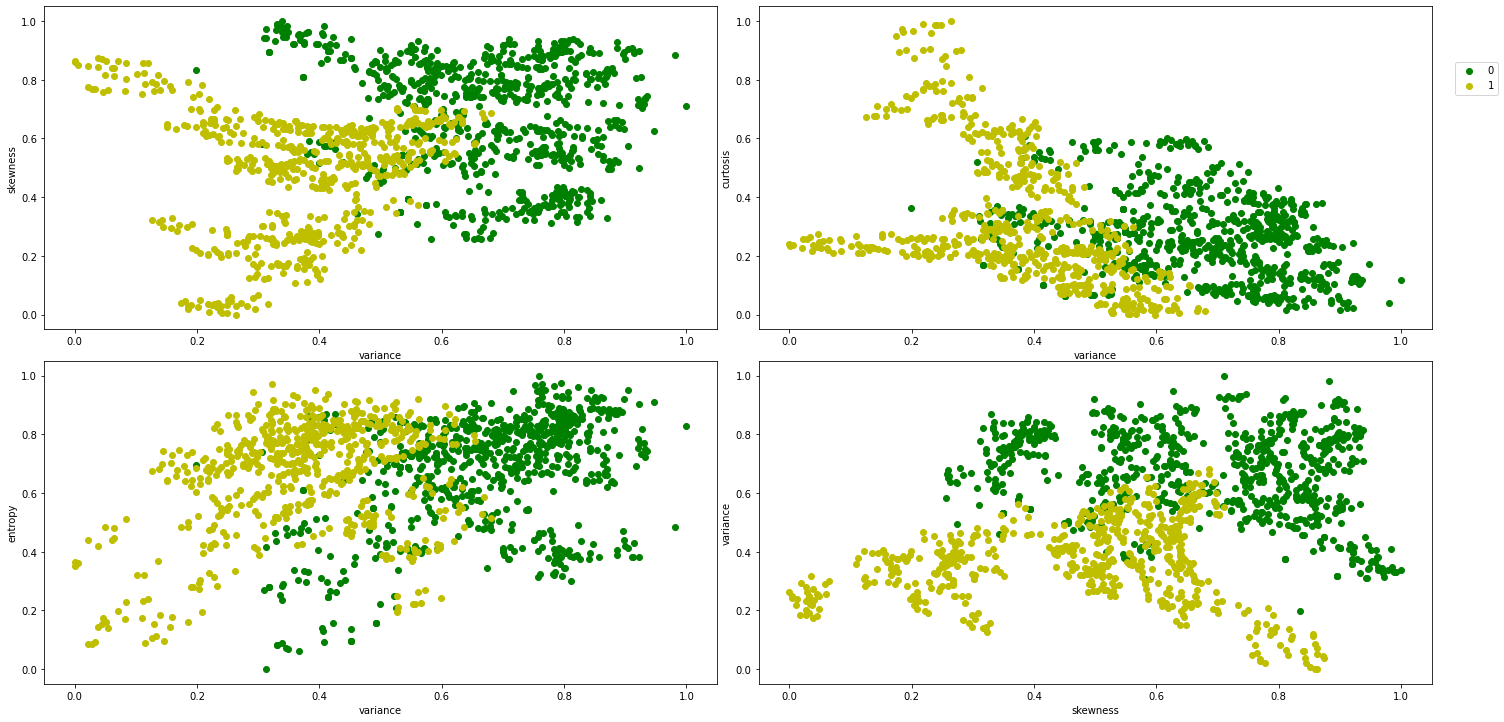

In [102]:
visualizeData(banknote_df)

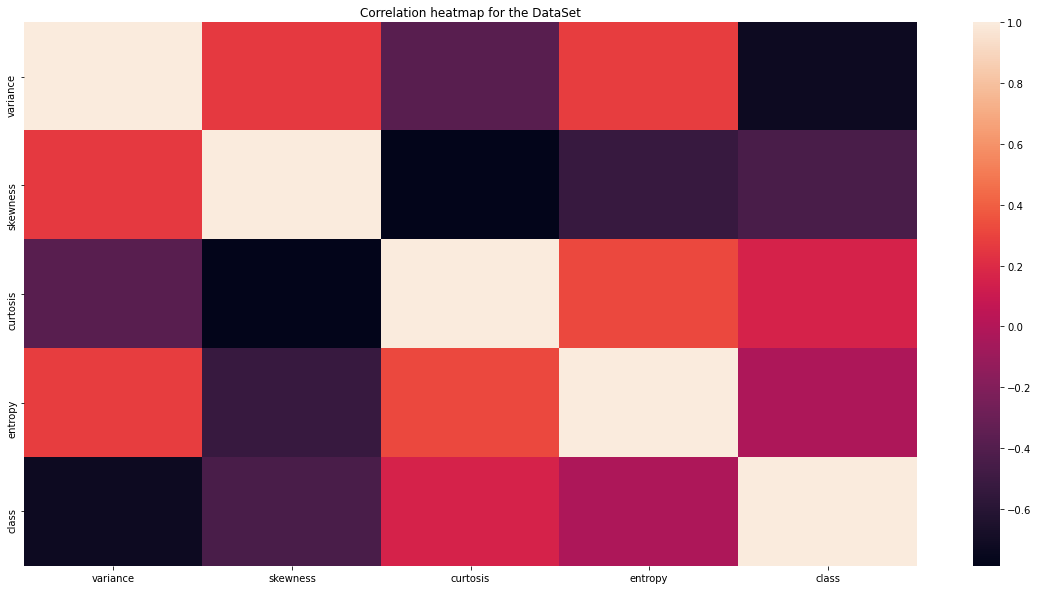

,variance,skewness,curtosis,entropy,class
0,0.769004,0.839643,0.106783,0.736628,0
1,0.835659,0.820982,0.121804,0.644326,0
2,0.786629,0.416648,0.310608,0.786951,0
3,0.757105,0.871699,0.054921,0.450440,0
4,0.531578,0.348662,0.424662,0.687362,0
...,...,...,...,...,...
1367,0.537124,0.565855,0.165249,0.726398,1
1368,0.407690,0.332868,0.506753,0.808350,1
1369,0.237385,0.011768,0.985603,0.524755,1
1370,0.250842,0.201701,0.761587,0.660675,1


In [103]:
dataCorrelation(banknote_df)

In [104]:
X_train, X_test, y_train, y_test = split(banknote_df)

In [105]:
trainModel(X_train, X_test, y_train, y_test)

###############################################################################
The accuracy of model DecisionTreeClassifier is  0.88
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       254
           1       0.88      0.85      0.87       199

    accuracy                           0.88       453
   macro avg       0.88      0.88      0.88       453
weighted avg       0.88      0.88      0.88       453

Measuring Accuracy Using Cross-Validation


The score computed at each CV iteration of model DecisionTreeClassifier is :
[0.81521739 0.85869565 0.83695652 0.81521739 0.82608696 0.80434783
 0.85869565 0.80434783 0.82608696 0.79120879]
Accuracy obtained: 0.82 (+/- 0.04)


###############################################################################
The accuracy of model GaussianNB is  0.77
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       254
           1       0.75      0.70    

# Workflow on Kidney Disease DataSet

In [106]:
kidney = loadData("kidney_disease.csv")

In [107]:
kidney_df = preprocessing(kidney)

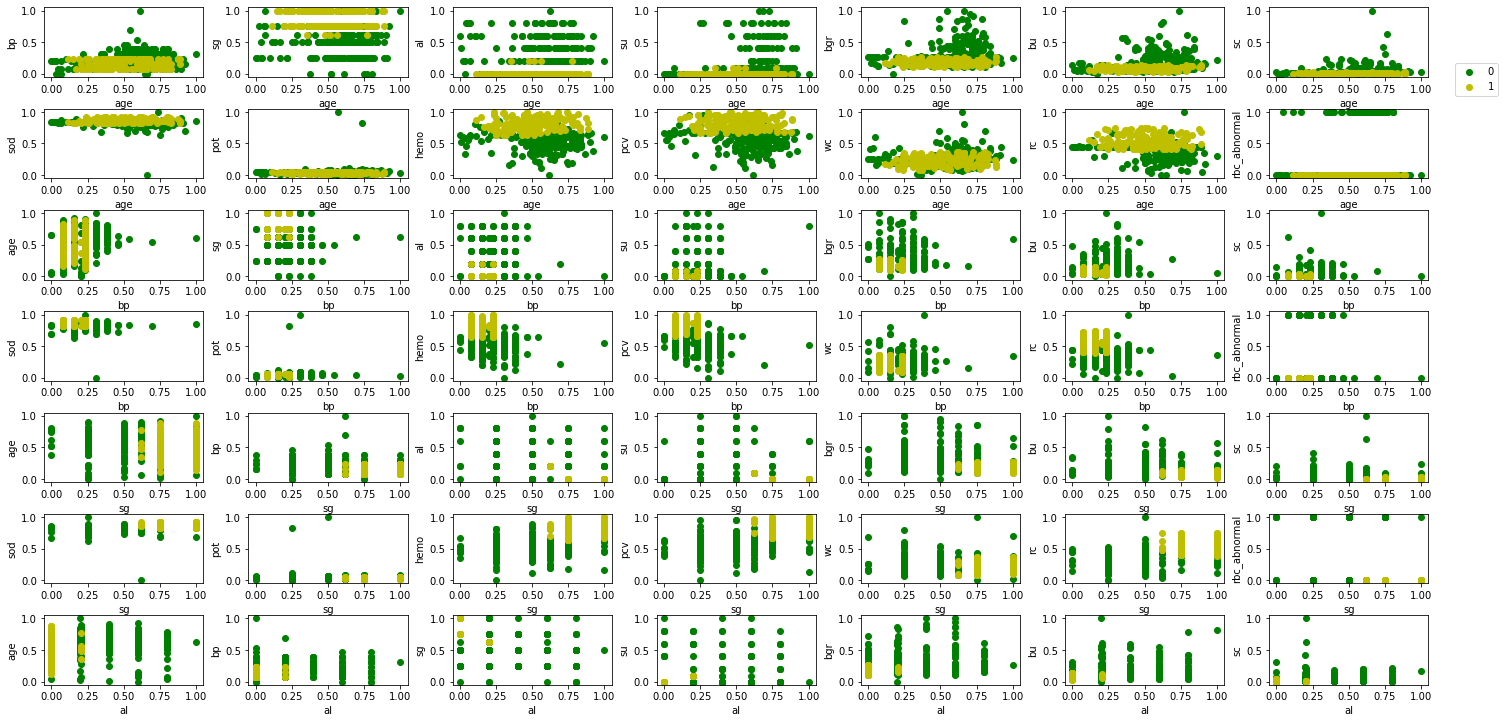

In [108]:
visualizeData(kidney_df)

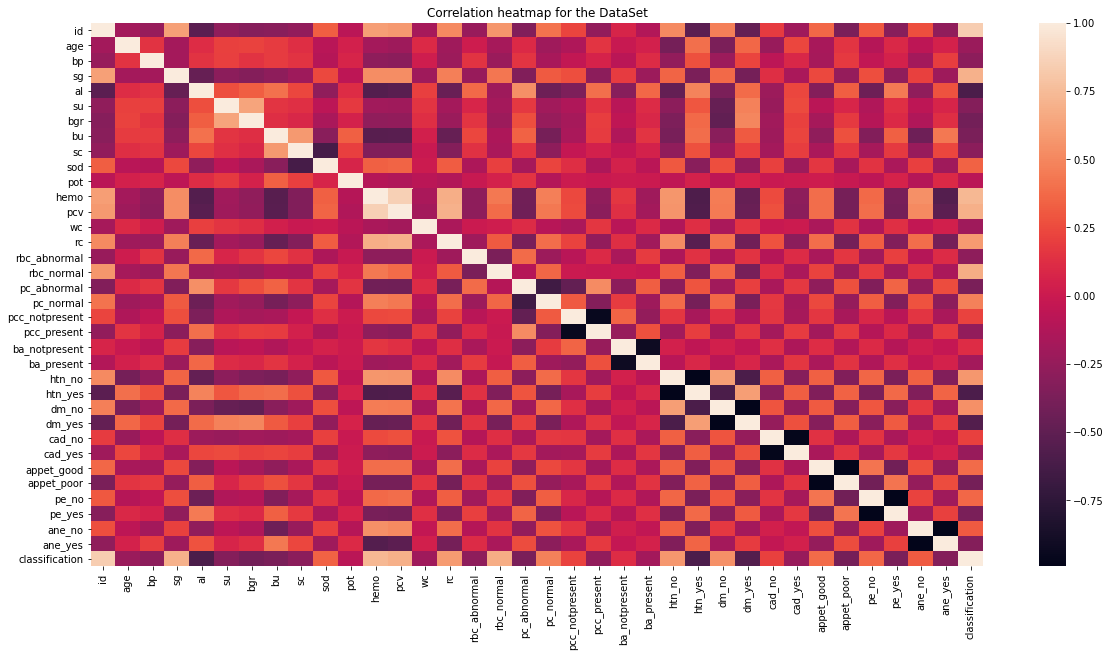

,id,age,bp,sg,al,su,bgr,bu,sc,sod,...,dm_yes,cad_no,cad_yes,appet_good,appet_poor,pe_no,pe_yes,ane_no,ane_yes,classification
0,0.000000,0.522727,0.230769,0.75,0.2,0.0,0.211538,0.088575,0.010582,0.839298,...,1,1,0,1,0,1,0,1,0,0
1,0.002506,0.056818,0.000000,0.75,0.8,0.0,0.269309,0.042362,0.005291,0.839298,...,0,1,0,1,0,1,0,1,0,0
2,0.005013,0.681818,0.230769,0.25,0.4,0.6,0.856838,0.132221,0.018519,0.839298,...,1,1,0,0,1,1,0,0,1,0
3,0.007519,0.522727,0.153846,0.00,0.8,0.0,0.202991,0.139923,0.044974,0.671924,...,0,1,0,0,1,0,1,0,1,0
4,0.010025,0.556818,0.230769,0.25,0.4,0.0,0.179487,0.062901,0.013228,0.839298,...,0,1,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.989975,0.602273,0.230769,0.75,0.0,0.0,0.252137,0.121951,0.001323,0.917981,...,0,1,0,1,0,1,0,1,0,1
396,0.992481,0.454545,0.153846,1.00,0.0,0.0,0.113248,0.075738,0.010582,0.861199,...,0,1,0,1,0,1,0,1,0,1
397,0.994987,0.113636,0.230769,0.75,0.0,0.0,0.166667,0.062901,0.002646,0.835962,...,0,1,0,1,0,1,0,1,0,1
398,0.997494,0.170455,0.076923,1.00,0.0,0.0,0.196581,0.124519,0.007937,0.823344,...,0,1,0,1,0,1,0,1,0,1


In [109]:
dataCorrelation(kidney_df)

In [110]:
X_train, X_test, y_train, y_test = split(kidney_df)

In [111]:
trainModel(X_train, X_test, y_train, y_test)

###############################################################################
The accuracy of model DecisionTreeClassifier is  0.99
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        79
           1       1.00      0.98      0.99        53

    accuracy                           0.99       132
   macro avg       0.99      0.99      0.99       132
weighted avg       0.99      0.99      0.99       132

Measuring Accuracy Using Cross-Validation


The score computed at each CV iteration of model DecisionTreeClassifier is :
[1.         0.96296296 1.         1.         0.92592593 1.
 1.         1.         1.         0.96153846]
Accuracy obtained: 0.99 (+/- 0.05)


###############################################################################
The accuracy of model GaussianNB is  0.95
              precision    recall  f1-score   support

           0       0.94      0.99      0.96        79
           1       0.98      0.91      0.94  